# Analysis of incorrectly solved puzzles

In this notebook, we look at the examples incorrectly solved by __AdjacencyClassifier_NoML__, __FromScratch__ and  __ResNetFT__ solvers. We display a thumbnail of the images incorrect solved and run the solvers again to see how they solved these images.

In [100]:
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib_venn import venn3, venn3_unweighted
import matplotlib.ticker as plticker
import os
import sys


import pprint
import itertools
from collections import defaultdict
import copy

# generate random integer values
import random
from random import seed
from random import randint
import numpy as np
import pandas as pd
from pylab import array
from random import sample
import math

import shelve

import torch
from torch.utils.data import Dataset, DataLoader, IterableDataset
from torchvision import transforms, utils
from torch import nn, optim
from torchvision import datasets, transforms
#from torchvision.utils import make_grid


from Puzzle_generator import *
from Checking_adjacency_dataset import *
from FromScratch_CNN import *
from ResNetFT_Finetuning import *
from Training_template import *
from Adjacency_distance import *
from Search_template import *

# Setting up

In [101]:
if torch.cuda.is_available():
    GpuAvailable=True
    my_device = torch.device("cuda:0")   
    print("Running on the GPU")
else:
    GpuAvailable=False
    my_device = torch.device("cpu")
    print("Running on the CPU")




Running on the CPU


In [102]:
#Input global variables
my_test_dir = os.getenv("MY_TEST_DIR")
my_puzzle_square_piece_dim = 75


In [103]:
my_learning_rate = 0.001
my_momentum = 0.9


In [104]:
model_names = ['AdjacencyClassifier_NoML', 'FromScratch', 'ResNetFT']
models = [AdjacencyClassifier_NoML()]
for i in [1,2]:
    model_name=model_names[i]
    model,loss_criterion,optimizer = make_model_lc_optimizer(model_name,
                                                             my_learning_rate,
                                                             my_momentum)
    best_model_path=f"./best_model_for_{model_name}.pt"
    model, optimizer, epochs_trained, min_val_loss = load_checkpoint_gpu(best_model_path,
                                                                         model, 
                                                                         optimizer,
                                                                         GpuAvailable)
    model.eval()
    models.append(model)
    if 'GpuAvailable':
        models[i].to(my_device)

    
    
    

Using FromScratch - Expect more number of parameters to learn!
	 bigunit.0.conv1.weight
	 bigunit.0.conv2.weight
	 bigunit.0.unit.2.weight
	 bigunit.0.unit.2.bias
	 bigunit.0.unit.5.weight
	 bigunit.0.unit.5.bias
	 bigunit.1.conv1.weight
	 bigunit.1.conv2.weight
	 bigunit.1.unit.2.weight
	 bigunit.1.unit.2.bias
	 bigunit.1.unit.5.weight
	 bigunit.1.unit.5.bias
	 bigunit.2.conv1.weight
	 bigunit.2.conv2.weight
	 bigunit.2.unit.2.weight
	 bigunit.2.unit.2.bias
	 bigunit.2.unit.5.weight
	 bigunit.2.unit.5.bias
	 bigunit.3.conv1.weight
	 bigunit.3.conv2.weight
	 bigunit.3.unit.2.weight
	 bigunit.3.unit.2.bias
	 bigunit.3.unit.5.weight
	 bigunit.3.unit.5.bias
	 bigunit.4.conv1.weight
	 bigunit.4.conv2.weight
	 bigunit.4.unit.2.weight
	 bigunit.4.unit.2.bias
	 bigunit.4.unit.5.weight
	 bigunit.4.unit.5.bias
	 bigunit.5.conv1.weight
	 bigunit.5.conv2.weight
	 bigunit.5.unit.2.weight
	 bigunit.5.unit.2.bias
	 bigunit.5.unit.5.weight
	 bigunit.5.unit.5.bias
	 fc1.weight
	 fc1.bias
	 bn1.weight


In [105]:
import time
def run_modified_solver(images,i):
    list_of_solved_images = []
    list_of_titles = []
    for pos,image_name in enumerate(images):
        my_model_name = model_names[i]
        my_model = models[i]
        output = modified_solve_example(img_path(image_name),my_puzzle_square_piece_dim,
                                        my_model_name, my_model,show_solving_progress=False,
                                        input_display=False)
        file_name, pieces, correct_position, correct_position_and_rotation, solved_image = output
        list_of_solved_images.append(solved_image)
        list_of_titles.append(f'{correct_position_and_rotation}/{pieces}')
        print(f"Image #{pos} processed")
        
    return list_of_solved_images, list_of_titles


# Thumbnails of incorrectly solved puzzles

In [106]:
def img_path(image_name):
    return os.path.join(my_test_dir, '..', image_name)

In [118]:
def show_images(images, cols, titles = [],  new_size = (300,300), is_pil= False):
    
    n = len(images)
    rows = math.ceil(n/cols)
    fig = plt.figure(dpi = 150)
    plt.rcParams.update({'font.size':6})
    for i in range(1, 1+n):
        if not is_pil:
            image_file_name = img_path(images[i-1])
            my_image = Image.open(image_file_name)
            my_image = my_image.resize(new_size) 
        else:
            my_image=images[i-1]
        ax = fig.add_subplot(rows,cols,i)
        ax.imshow(my_image)
        ax.axis('off')
        if titles:
            ax.set_title(titles[i-1])
    plt.tight_layout()

In [108]:
# Getting the shelfed data
shelfFile = shelve.open('mydata')
unsolved_indices_dict = shelfFile["unsolved_indices_dict"] 
unsolved_images_dict = shelfFile["unsolved_images_dict"]
shelfFile.close()

## Unsolved by all of the models

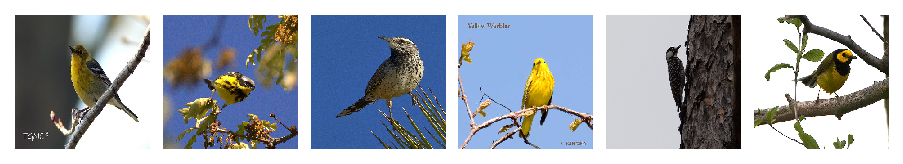

In [124]:
unsolved_by_all = list(unsolved_images_dict["All"])
show_images(unsolved_by_all, 6)

## Unsolved by AdjacencyClassifier_NoML but solved by ResNetFT

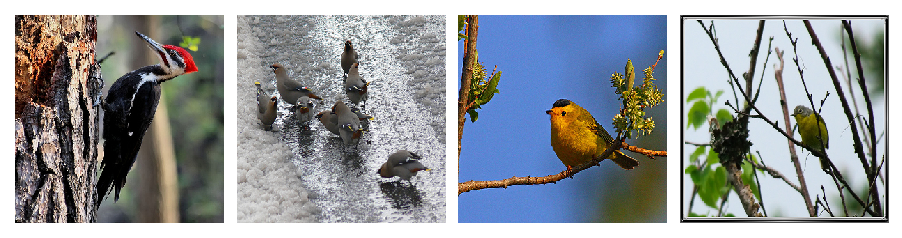

In [130]:
unsolved_by_adj_no_ml_but_solved_by_resnet = list(unsolved_images_dict["AdjacencyClassifier_NoML"]-unsolved_images_dict["All"])
show_images(unsolved_by_adj_no_ml_but_solved_by_resnet, 4)

## Unsolved by ResNetFT but solved by AdjacencyClassifier_NoML

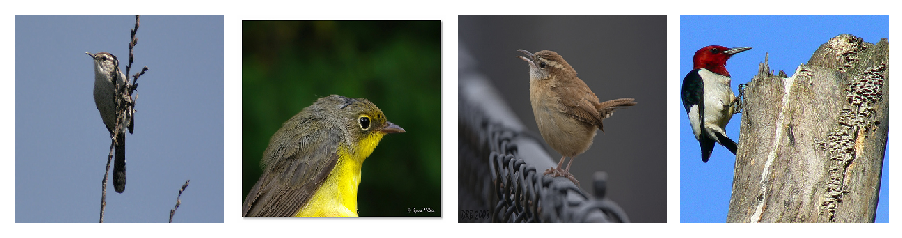

In [131]:
unsolved_by_resnetft_but_solved_by_adj_no_ml = list(unsolved_images_dict["ResNetFT"]-unsolved_images_dict["All"])
show_images(unsolved_by_resnetft_but_solved_by_adj_no_ml, 4)

# AdjacencyClassifier_NoML

## Incorrectly solved

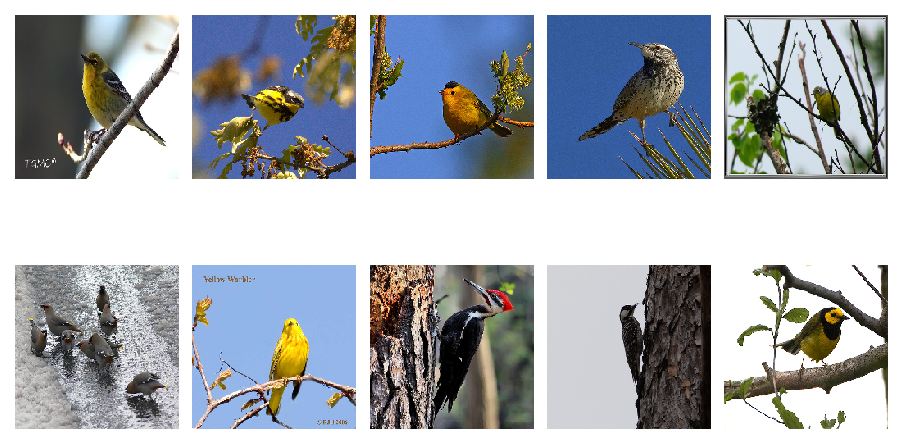

In [125]:
unsolved_by_adj_no_ml = list(unsolved_images_dict["AdjacencyClassifier_NoML"])
show_images(unsolved_by_adj_no_ml, 5, [], (200,200))

## How AdjacencyClassifier_NoML solved these

Image #0 processed
Image #1 processed
Image #2 processed
Image #3 processed
Image #4 processed
Image #5 processed
Image #6 processed
Image #7 processed
Image #8 processed
Image #9 processed


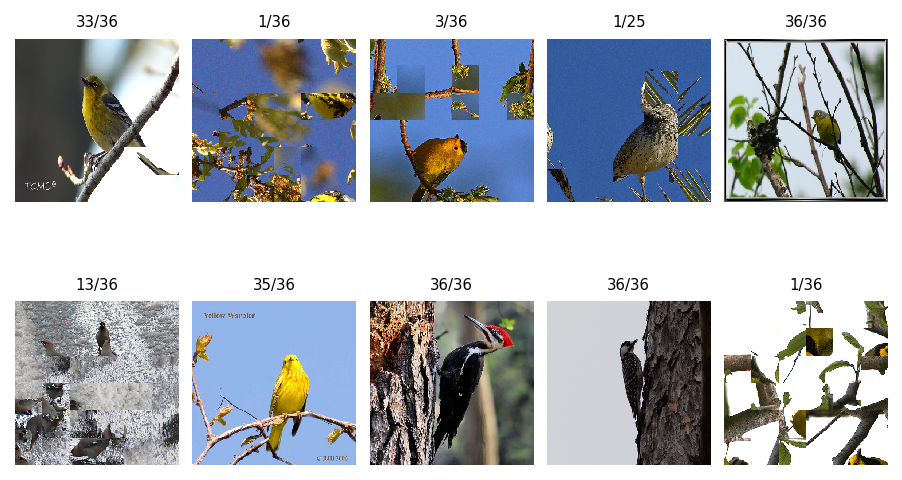

In [127]:
solved_imgs_by_adj_no_ml, titles = run_modified_solver(unsolved_by_adj_no_ml,0)
show_images(solved_imgs_by_adj_no_ml, 5, titles , new_size = (300,300), is_pil= True)

# ResNetFT

## Incorrectly solved

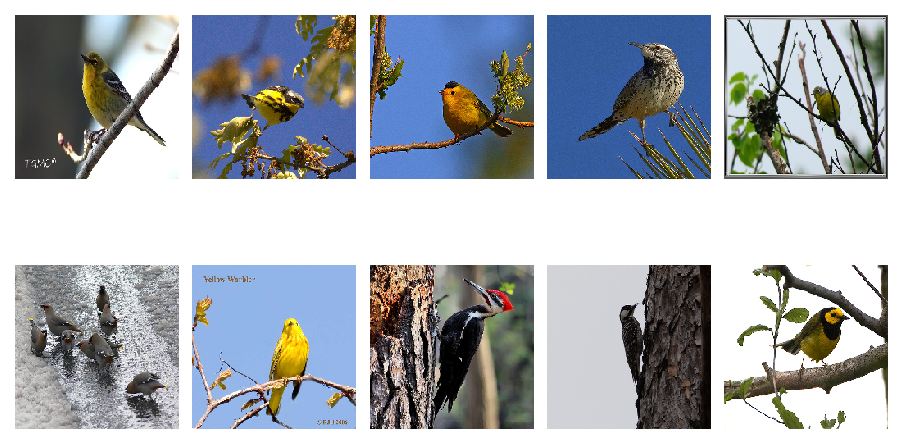

In [132]:
unsolved_by_resnetft = list(unsolved_images_dict["ResNetFT"])
show_images(unsolved_by_adj_no_ml, 5, [], (200,200))



## How ResNetFT solved these

Image #0 processed
Image #1 processed
Image #2 processed
Image #3 processed
Image #4 processed
Image #5 processed
Image #6 processed
Image #7 processed
Image #8 processed
Image #9 processed


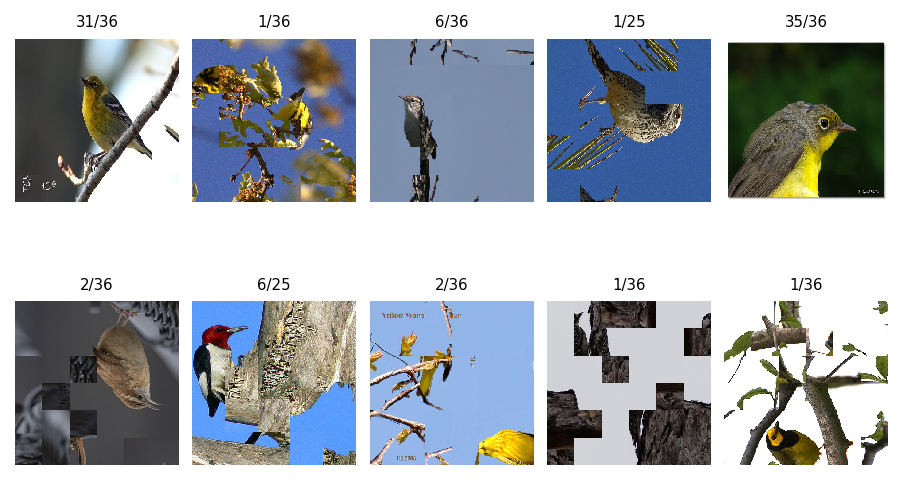

In [135]:
solved_imgs_by_resnetft, titles = run_modified_solver(unsolved_by_resnetft,2)
show_images(solved_imgs_by_resnetft, 5, titles , new_size = (300,300), is_pil= True)

# FromScratch

## Incorrectly solved

FromScratch solved 50 of the 80 images incorrectly. We give a sample of size 10 below

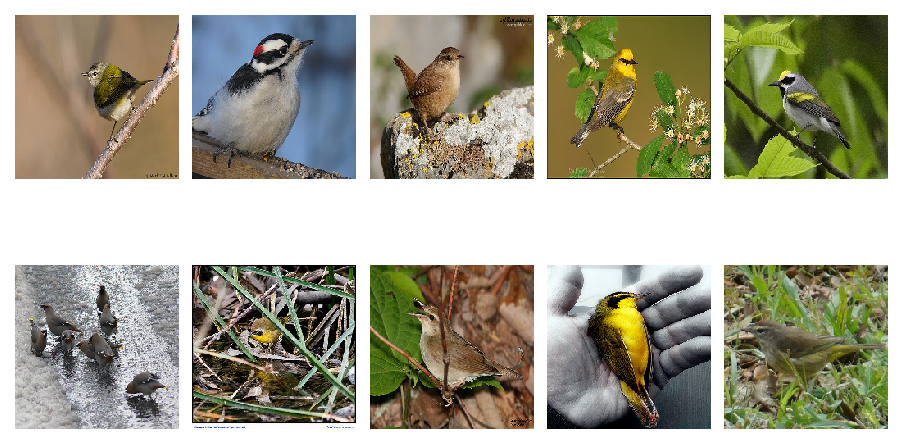

In [133]:
unsolved_by_fromscratch = list(unsolved_images_dict["FromScratch"])
unsolved_by_fromscratch = random.sample(unsolved_by_fromscratch,10) 
show_images(unsolved_by_fromscratch, 5, [], (200,200))

## How FromScratch solved these


Image #0 processed
Image #1 processed
Image #2 processed
Image #3 processed
Image #4 processed
Image #5 processed
Image #6 processed
Image #7 processed
Image #8 processed
Image #9 processed


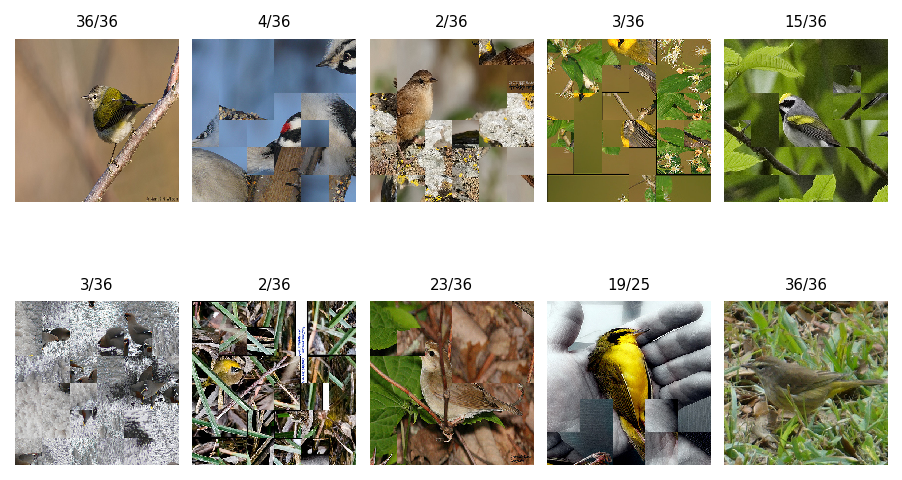

In [134]:
solved_imgs_by_fromscratch, titles = run_modified_solver(unsolved_by_fromscratch,1)
show_images(solved_imgs_by_fromscratch, 5, titles , new_size = (300,300), is_pil= True)

# Comments

We further visually investigated what the models did on puzzles they did not solve completely correctly. It turned out that the solvers were putting together several chunks of the puzzles correctly even if they were not placing the pieces in the correct positions in the puzzle board. Further, the solvers sometimes put back mostly correct but rotated versions of the images. Our current evaluation classified all these puzzles as _unsolved_.


If there are several similar pieces, and a solver chose and fit an incorrect piece, the puzzle of course will not be completely correctly solved. However the solver might (and did often) recover and get local chunks of the puzzle right. Perhaps a non-binary evaluation metric would aid in gauging the efficacy of these puzzle-solvers.

As a side note, we observe that there is some randomness in the search algorithm. If there are several choices for the best fit (piece, orientation, open-slot) combination, the solver arbitrarily picks one of them. This leads to slightly differing results on different runs